In [1]:
%load_ext line_profiler

In [8]:
%%writefile simulation.py

import os
import sys
import time
from tqdm.autonotebook import tqdm
import torch
# sys.path.append('../')
from LogSinkhornGPU import *
from LogSinkhornGPUBackend import InnerNewtonCUDA
import pykeops
import numpy as np
import matplotlib.pyplot as plt

def check():
    print(f'which python3:   {sys.executable}')
    print(f'LD_LIBRARY_PATH: {os.environ["LD_LIBRARY_PATH"]}\n')
    print(f'torch version:   {torch.__version__}')
    print(f'torch file:      {torch.__file__}')
    print(f'cuda available:  {torch.cuda.is_available()}')
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print('device name:    ', torch.cuda.get_device_name(i))
    print('')


class SubdomainUnbalancedSinkhornTorch(AbstractSinkhorn):
    '''
    Unbalanced Log Sinkhorn on Subdomain (J-Cell) with torch.
    '''

    def __init__(self, mu, nu, C, eps, **kwargs):
        # self.n_pixels = mu.shape[0]
        # self.partition = kwargs["partition"]
        # self.J = kwargs["J"]
        # self.pi = kwargs["pi"]
        self.nu_nJ = kwargs["nu_nJ"]
        self.lognu_nJ = log_dens(self.nu_nJ)
        self.t = kwargs["t"]
        self.lam = kwargs["lam"]
        self.scale = eps/(1.0 + eps/self.lam)
        self.newton_iter = kwargs["newton_iter"]
        self.newton_tol = kwargs["newton_tol"]
        super().__init__(mu, nu, C, eps, **kwargs)

    def get_new_alpha(self):
        return -self.scale * (
            softmin_torch(
                (self.beta[:, None, :] - self.C) / self.eps
                + self.lognuref[:, None, :],
                dim=2
            )
            + self.logmuref - self.logmu
        )

    def get_new_beta(self):
        logKTu = softmin_torch(
            (self.alpha[:, :, None] - self.C) / self.eps
            + self.logmuref[:, :, None] + self.lognuref[:, None, :], dim=1
        )
        self.t = InnerNewtonCUDA(
            self.newton_iter, self.newton_tol, self.t, self.eps, self.lam, 
            self.lognu, self.lognu_nJ, logKTu
        )
        return -self.lam*self.t - self.eps*logKTu

    def get_pi_dense(self):
        return torch.exp(
            (self.alpha[:, :, None]+self.beta[:, None, :]-self.C) / self.eps
            + self.logmuref[:, :, None] + self.lognuref[:, None, :]
        )

    def get_current_error(self):
        """
        Get current error for unbalanced Sinkhorn
        """
        new_alpha = self.get_new_alpha()
        # Compute current marginal
        new_mu = self.mu * torch.exp((self.alpha - new_alpha)/self.scale)
        # Update alpha (we get an iteration for free)
        self.alpha = new_alpha
        # Finish this sinkhorn iter
        self.update_beta()
        # Return L1 error
        return torch.sum(torch.abs(self.mu - new_mu))


def batch_iteration(pi, x, y, muref, nuref, eps, lam, partition, device='cuda'):
    B = len(partition)
    n_pixels = len(y)
    max_cell_size = np.max(list(map(len, partition)))
    Mu = torch.zeros((B, max_cell_size), device=device)
    Nu = torch.zeros((B, n_pixels), device=device)
    Muref = torch.zeros((B, max_cell_size), device=device)
    Nuref = torch.zeros((B, n_pixels), device=device)
    C = torch.zeros((B, max_cell_size, n_pixels), device=device)

    t = torch.zeros((B, n_pixels), device=device)
    # t = 100*torch.ones((B, n_pixels), device=device)
    Nu_nJ = torch.zeros((B, n_pixels), device=device)

    # Batch problems
    for i, J in enumerate(partition):
        piJ = pi[J, :]
        xJ = x[J]
        muJ = torch.sum(piJ, dim=1).ravel()
        # nuJ = torch.sum(piJ, dim=0).ravel()
        nu = torch.sum(pi, dim=0).ravel()
        Mu[i, :len(J)] = muJ
        Nu[i, :] = nu
        Muref[i, :len(J)] = muref[0, J]
        # Muref[i, :] = muref[0, J]  # same as above?
        Nuref[i, :] = nuref[0, :]
        C[i, :len(J), :] = (xJ.reshape(-1, 1) - y.reshape(1, -1))**2

        nJ = list(set(range(n_pixels)) - set(J))
        nu_nJ = torch.sum(pi[nJ, :], axis=0).ravel()
        # print('nu_nJ: ', nu_nJ)
        Nu_nJ[i, :] = nu_nJ

    solver = SubdomainUnbalancedSinkhornTorch(
        Mu, Nu, C, eps, muref=Muref, nuref=Nuref,
        lam=lam, t=t, nu_nJ=Nu_nJ,
        newton_iter=10, newton_tol=1e-10,
    )

    solver.iterate_until_max_error()
    # Retrieve solution
    pi_batch = solver.get_pi_dense()
    pi_new = torch.zeros_like(pi)
    for i, J in enumerate(partition):
        pi_new[J, :] = pi_batch[i, :len(J), :]
    return pi_new


def main():
    device = 'cuda'
    M = N = 32
    muref = torch.ones(1, M, device=device)
    nuref = torch.ones(1, N, device=device)
    muref = muref/torch.sum(muref, dim=1, keepdim=True)
    nuref = nuref/torch.sum(nuref, dim=1, keepdim=True)
    x = torch.linspace(0, 1, M, device=device)
    y = torch.linspace(0, 1, N, device=device)

    # Create partitions
    partA = [[i, i+1] for i in range(0, N, 2)]
    partB = [[0], *[[i, i+1] for i in range(1, N-2, 2)], [N-1]]

    # Create initial transport plan
    pi = torch.ones((M, N), device=device) / (M*N)  # prod initialization
    # pi = torch.fliplr(torch.eye(M, device=device))/M

    eps = 1/M**2
    lam = 1000
    n_iter = 20

    cols = 5
    rows = (n_iter-1)//cols + 1
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(2*cols, 2*rows))

    for i, ax in tqdm(enumerate(axs.flatten())):
        partition = partA if i % 2 == 0 else partB
        pi = batch_iteration(
            pi, x, y, muref, nuref, eps, lam, partition
        )
        ax.imshow(pi.cpu().detach().T, origin="lower")

    fig.tight_layout()
    plt.show()


if __name__ == '__main__':
    # check()
    main()

Overwriting simulation.py


0it [00:00, ?it/s]

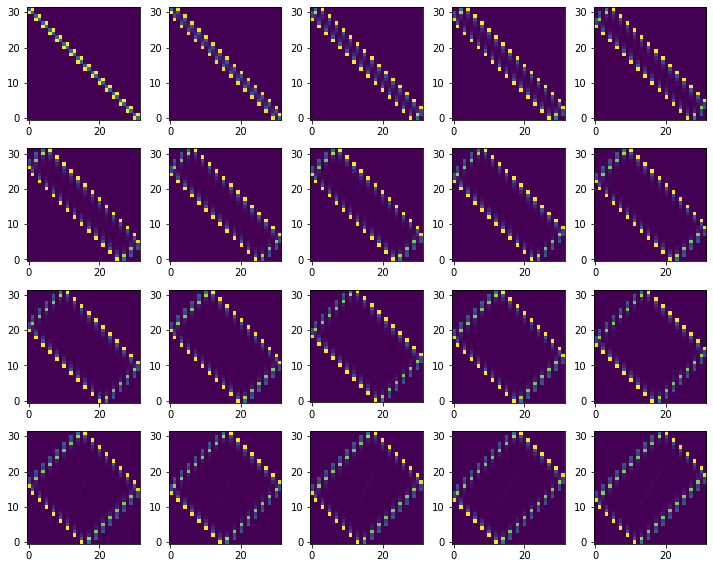


*** Profile printout saved to text file 'lprun_output'. 


Timer unit: 1e-09 s

Total time: 17.4174 s
File: /scratch1/users/nguyen45/LogSinkhornGPU/examples/simulation.py
Function: get_new_beta at line 55

Line #      Hits         Time  Per Hit   % Time  Line Contents
    55                                               def get_new_beta(self):
    56    105020 6480726562.0  61709.5     37.2          logKTu = softmin_torch(
    57    315060 5089501556.0  16154.1     29.2              (self.alpha[:, :, None] - self.C) / self.eps
    58    210040 1700524761.0   8096.2      9.8              + self.logmuref[:, :, None] + self.lognuref[:, None, :], dim=1
    59                                                   )
    60    105020 1100491348.0  10478.9      6.3          self.t = InnerNewtonCUDA(
    61    105020   58032298.0    552.6      0.3              self.newton_iter, self.newton_tol, self.t, self.eps, self.lam, 
    62    105020   28510202.0    271.5      0.2              self.lognu, self.lognu_nJ, logKTu
    63                                  

In [9]:
from simulation import main
from simulation import SubdomainUnbalancedSinkhornTorch as sus

%lprun -T lprun_output -f sus.get_new_beta main()

In [6]:
print(open('lprun_output', 'r').read())